In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp

from jax.flatten_util import ravel_pytree
from jax.scipy.special import logsumexp

import blackjax
import numpyro as npr
import numpyro.distributions as dist
import numpyro.distributions.transforms as nprb
import numpyro.distributions.constraints as constraints
from numpyro.distributions.transforms import Transform

import sys

import bamojax
from bamojax.base import Model
from bamojax.samplers import mcmc_sampler
from bamojax.inference import SMCInference, MCMCInference
from bamojax.marginal_likelihoods.bridge_sampling import bridge_sampling


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Bamojax version:    ', bamojax.__version__)
print('Numpyro version:    ', npr.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Jax version:         0.7.2
BlackJax version:    1.2.5
Bamojax version:     0.3.4+0.g3c4f67a.dirty
Numpyro version:     0.19.0
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


# Bridge sampling implementation in **bamojax**

Based on Gronau et al. (2017).

First, we set up the toy example model:

In [3]:
z, N = 2, 10
a, b = 1, 1

beta_binom = Model('beta-binomial')

theta_node = beta_binom.add_node('theta', distribution=dist.Beta(concentration1=a, concentration0=b))
z_node = beta_binom.add_node('z', distribution=dist.Binomial, parents=dict(probs=theta_node, total_count=N), observations=z)

Obtain posterior samples

In [4]:
N1 = 5_000
key = jrnd.PRNGKey(0)
key, subkey = jrnd.split(key)

m = beta_binom.get_model_size()
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(m))  # these will be overriden by the window adaptation
nuts_kernel = mcmc_sampler(model=beta_binom, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)

# we want to sample twice as many samples, since we need them for constructing the bridge density as well as for...
engine = MCMCInference(model=beta_binom, mcmc_kernel=nuts_kernel, num_samples=2*N1, num_burn=0, num_warmup=1_000, num_thin=1)
results = engine.run(subkey)

posterior_samples = results['states']

Adapting NUTS HMC parameters... done.


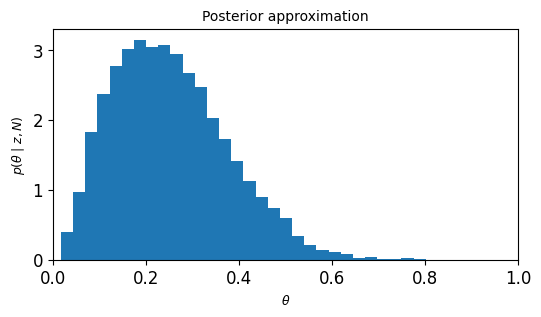

In [5]:
plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.hist(posterior_samples['theta'], density=True, bins=30)
ax.set_xlabel(r'$\theta$', fontsize=9)
ax.set_ylabel(r'$p(\theta\mid z,N)$', fontsize=9);
ax.set_title('Posterior approximation', fontsize=10)
ax.set_xlim(0, 1);

In [6]:
from jax.scipy.special import betaln, gammaln

def binomln(N, k):
    return gammaln(N + 1) - gammaln(k + 1) - gammaln(N - k + 1)


true_Z = jnp.exp(binomln(N, z) + betaln(z + a, N - z + b) - betaln(a, b))
print(f'True marginal likelihood: {true_Z:.4f}')

True marginal likelihood: 0.0909


To replicate Gronau's example, we need the NormalCDF/Probit transform, which is not native to Numpyro. However, it is straightforward to implement:

In [7]:
class ProbitTransform(Transform):

    def __init__(self, domain=constraints.real):
        self.domain = domain
        self.codomain = constraints.unit_interval

    #
    def __call__(self, x):
        # forward: R -> (0,1)
        return 0.5 * (1.0 + jax.lax.erf(x / jnp.sqrt(2.0)))

    #
    def _inverse(self, y):
        # inverse: (0,1) -> R  (clipped for numerical stability)
        return jnp.sqrt(2.0) * jax.scipy.special.erfinv(2.0 * y - 1.0)

    #
    def log_abs_det_jacobian(self, x, y, intermediates=None):
        # log |dΦ/dx| = log φ(x) = -0.5 x^2 - 0.5 log(2π)
        return -0.5 * x**2 - 0.5 * jnp.log(2.0 * jnp.pi)

    #
    def tree_flatten(self):
        return (self.domain,), (("domain",), dict())
    
    #

#

## Bridge sampling algorithm

Will be moved to `marginal_likelihoods.py`.

In [10]:
bridge_sampling_bijectors = dict(theta=ProbitTransform())

bridge_sampling_estimate = bridge_sampling(key=jrnd.PRNGKey(0),
                                           model=beta_binom, 
                                           posterior_samples=posterior_samples, 
                                           bijectors=bridge_sampling_bijectors, 
                                           proposal_type='gaussian', N2=1000)

print('beta-binomial marginal likelihood:', jnp.exp(bridge_sampling_estimate[0]))

beta-binomial marginal likelihood: 0.09073947011147135


Try on a new model now:

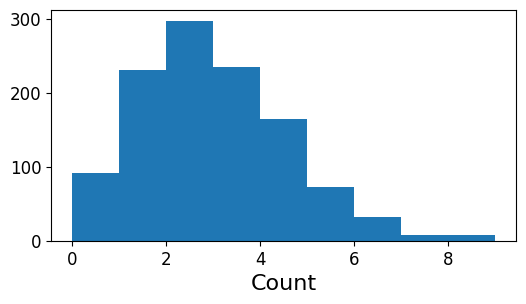

In [11]:
import pandas as pd

files = ['2005-06', '2006-07', '2007-08']
goals = []

for year in files:
    df = pd.read_csv(f'/scratch/big/home/maxhin/Documents/Code/Bayesian Model Comparison/data/English premiership/{year}.csv')  
    total_goals = df['FTHG'] + df['FTAG']
    total_goals_array = total_goals.to_numpy()
    goals.extend(total_goals_array)

Y = jnp.array(goals)
n = len(Y)
plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.hist(Y, bins=jnp.arange(0, 10, 1))
ax.set_xlabel('Goals')
ax.set_xlabel('Count');

In [12]:
def construct_poisson_model(observations) -> Model:
    model = Model('Poisson')
    rate_node = model.add_node('lam', distribution=dist.Gamma(concentration=25, rate=10))
    _ = model.add_node('Y', observations=observations, parents=dict(rate=rate_node), distribution=dist.Poisson)
    return model

#
def construct_negative_binomial_model(observations) -> Model:
    # Note: Hastie & Green, Wikipedia, and TFD all have their own parametrizations of the negative binomial
    def negbin_link_fn(rate, dispersion):
        p = rate / (rate + 1 / dispersion)
        r = 1 / dispersion
        return dict(probs=p, total_count=r)

    #

    model = Model('Negative binomial')
    rate_node = model.add_node('lam', distribution=dist.Gamma(concentration=25, rate=10)) 
    dispersion_node = model.add_node('kappa', distribution=dist.Gamma(concentration=1, rate=10))  
    _ = model.add_node('Y', observations=observations, parents=dict(rate=rate_node, dispersion=dispersion_node), distribution=dist.NegativeBinomialProbs, link_fn=negbin_link_fn)
    return model

#

poisson_model = construct_poisson_model(Y)
negbin_model = construct_negative_binomial_model(Y)

In [13]:
%%time

models = [poisson_model, negbin_model]
num_mutations = 100
results = {}

for model in models:
    print(f'Inference for {model.name} model')
    mcmc_params = dict(sigma=0.1*jnp.eye(model.get_model_size()))
    rmh_kernel = mcmc_sampler(model, mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=mcmc_params)

    num_particles = 5_000
    num_chains = 1

    key = jrnd.PRNGKey(0)
    engine = SMCInference(model=model, num_chains=num_chains, mcmc_kernel=rmh_kernel, num_particles=num_particles, num_mutations=num_mutations)
    result = engine.run(key)
    results[model.name] = result


Inference for Poisson model
Inference for Negative binomial model
CPU times: user 1min 30s, sys: 1.62 s, total: 1min 32s
Wall time: 1min 32s


In [14]:
poisson_bijectors = dict(lam=nprb.ExpTransform())

lml_poisson, _ = bridge_sampling(key=jrnd.PRNGKey(0),
                                 model=poisson_model, 
                                 posterior_samples=results[poisson_model.name]['final_state'].particles, 
                                 bijectors=poisson_bijectors, 
                                 proposal_type='gaussian', N2=1000)

print('Log marginal likelihood Poisson model:', lml_poisson)

negbin_bijectors = dict(lam=nprb.ExpTransform(), kappa=nprb.ExpTransform())

lml_negbin, _ = bridge_sampling(key=jrnd.PRNGKey(1),
                                model=negbin_model,
                                posterior_samples=results[negbin_model.name]['final_state'].particles, 
                                bijectors=negbin_bijectors, 
                                proposal_type='gaussian', N2=1000)

print('Log marginal likelihood negative binomial model:', lml_negbin)


BF_poisson_negbin = jnp.exp(lml_poisson - lml_negbin)
pmp_poisson = BF_poisson_negbin / (1 + BF_poisson_negbin)
pmp_negbin = 1 - pmp_poisson

print(f'Posterior model probability Poisson model: {pmp_poisson:0.3f}', flush=True)
print(f'Posterior model probability Negative-Binomial model: {pmp_negbin:0.3f}', flush=True)

Log marginal likelihood Poisson model: -2105.5046099154274
Log marginal likelihood negative binomial model: -2106.4151302478485
Posterior model probability Poisson model: 0.713
Posterior model probability Negative-Binomial model: 0.287


These results all confirm the Hastie & Green example.